In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, GRU, LayerNormalization, GlobalAvgPool1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from pyvi import ViTokenizer
from pyvi import ViUtils

In [20]:
dataset='SmallData.csv'

In [21]:
df = pd.read_csv(dataset)
print(df)

                                               content  rating
0      tiki giao hàng nhanh chóng, hàng đẹp chất lượng       5
1                              Giữ nhiệt tương đối tốt       4
2                                   + Cây lau cứng cáp       5
3                                       Giao hàng nhà        4
4     Hiếm có nơi nào làm được như vậy, sẽ ủng hộ tiếp       5
..                                                 ...     ...
695                          Bị ngắt mạch khi sạc pin        1
696  Tổng kết là, trải nghiệm nhận hàng lần này quá...       1
697                        Cây lau ko xoay 360 độ được       3
698  hướng dẫn lắp ráp sơ sài, không chi tiết làm m...       3
699      Check mã thì toàn kêu k có thông tin mua hàng       1

[700 rows x 2 columns]


In [22]:
sentiment_data=pd.DataFrame({'input':df['content'],'label':df['rating']})
sentiment_data['label'] = sentiment_data['label'].replace({1: 'Tiêu cực', 2: 'Tiêu cực', 3: 'Tiêu cực', 4: 'Tích cực', 5: 'Tích cực'})
sentiment_data=sentiment_data.dropna()
sentiment_data=sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,label
0,"tiki giao hàng nhanh chóng, hàng đẹp chất lượng",Tích cực
1,Giữ nhiệt tương đối tốt,Tích cực
2,+ Cây lau cứng cáp,Tích cực
3,Giao hàng nhà,Tích cực
4,"Hiếm có nơi nào làm được như vậy, sẽ ủng hộ tiếp",Tích cực


In [23]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

label_dict = {'Tiêu cực': 0, 'Tích cực': 1}

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
    #Loại bỏ các ký tự không phải chữ cái và không phải số, chuyển đổi thành chữ thường, tách câu thành các từ riêng biệt dựa trên dấu cách
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    #Loại bỏ dấu
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])


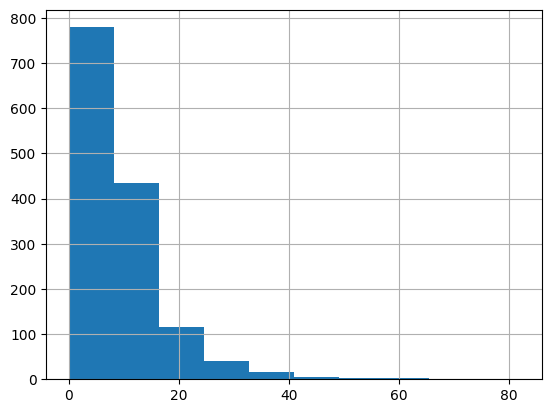

In [24]:
seq_len = [len(i.split()) for i in input_pre[0:10000]]
pd.Series(seq_len).hist(bins=10)
plt.show()


In [25]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')

tokenizer_data = Tokenizer(oov_token='<OOV>', filters='', split=' ')
tokenizer_data.fit_on_texts(input_pre)

tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=50)

pickle.dump(tokenizer_data,open("tokenizer_data.pkl","wb"))

print("input data.shape",vec_data.shape)
data_vocab_size=len(tokenizer_data.word_index)+1
print("data_vocab_size: ",data_vocab_size)

X_train, X_val, y_train, y_val=train_test_split(vec_data, label_tf, test_size=0.2, random_state=15)
X_train, X_test, y_train, y_test=train_test_split(X_train, y_train, test_size=0.1, random_state=10)

print("Training sample: ",len(X_train))
print("Validation sample: ",len(X_val))
print("Test sample: ",len(X_test))




input data.shape (1398, 50)
data_vocab_size:  1860
Training sample:  1006
Validation sample:  280
Test sample:  112


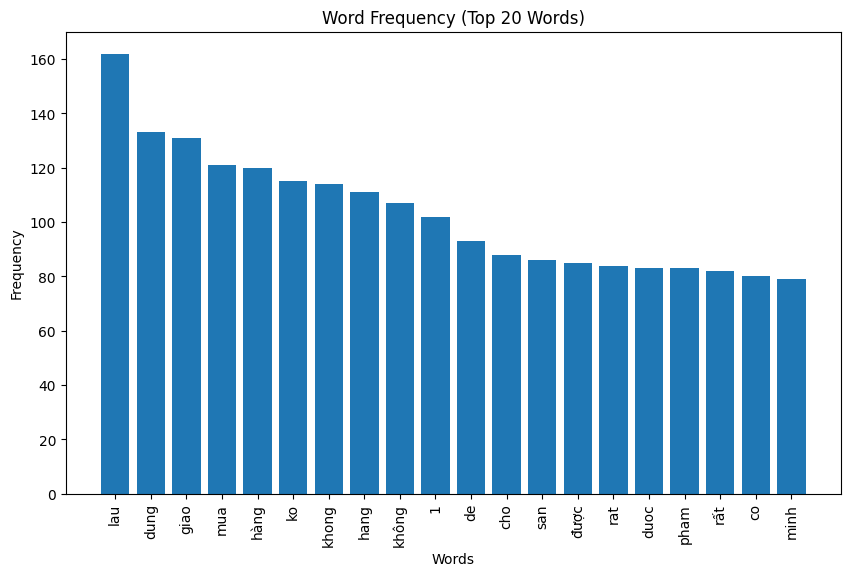

In [26]:
import matplotlib.pyplot as plt

num_words = 20  # Số từ vựng muốn hiển thị
word_counts = tokenizer_data.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
words = [word for word, count in sorted_word_counts[:num_words]]
counts = [count for word, count in sorted_word_counts[:num_words]]

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts)
plt.xticks(range(len(words)), words, rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency (Top {} Words)'.format(num_words))
plt.show()

In [27]:
def generate_model():
    dropout_threshold=0.4
    input_dim=data_vocab_size
    output_dim=32
    input_length=50
    initializer=tf.keras.initializers.GlorotNormal()

    input_layer=Input(shape=(input_length))

    feature=Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature=Conv1D(filters=32,kernel_size=3,padding='same',activation='relu')(feature)
    cnn_feature=MaxPooling1D()(cnn_feature)
    cnn_feature=Dropout(dropout_threshold)(cnn_feature)
    cnn_feature=Conv1D(filters=32,kernel_size=3,padding='same',activation='relu')(cnn_feature)
    cnn_feature=MaxPooling1D()(cnn_feature)
    cnn_feature=LayerNormalization()(cnn_feature)
    cnn_feature=Dropout(dropout_threshold)(cnn_feature)

    # Add a Conv1D layer to match the shape of the second input
    #bi_lstm_feauture=Conv1D(filters=64,kernel_size=3,padding='same',activation='relu')(feature)
    bi_lstm_feauture=Bidirectional(LSTM(units=32,dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
    bi_lstm_feauture=MaxPooling1D()(bi_lstm_feauture)

    bi_lstm_feauture=Bidirectional(GRU(units=32,dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(bi_lstm_feauture)
    bi_lstm_feauture=MaxPooling1D()(bi_lstm_feauture)
    bi_lstm_feauture=LayerNormalization()(bi_lstm_feauture) 

    combine_feature=tf.keras.layers.Concatenate()([cnn_feature,bi_lstm_feauture])
    combine_feature=GlobalAvgPool1D()(combine_feature)
    combine_feature=LayerNormalization()(combine_feature)

    classsifier=Dense(90, activation='relu')(combine_feature)
    classsifier=Dropout(0.2)(classsifier)
    classsifier=Dense(70, activation='relu')(classsifier)
    classsifier=Dropout(0.2)(classsifier)
    classsifier=Dense(50, activation='relu')(classsifier)
    classsifier=Dropout(0.2)(classsifier)
    classsifier=Dense(30, activation='relu')(classsifier)
    classsifier=Dropout(0.2)(classsifier)
    classsifier=Dense(3, activation='softmax')(classsifier)

    model=tf.keras.Model(inputs=input_layer,outputs=classsifier)

    return model
model=generate_model()
adam=Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 32)       59520       ['input_3[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 50, 32)       3104        ['embedding_2[0][0]']            
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 25, 32)      0           ['conv1d_4[0][0]']               
                                                                                            

In [28]:
dot_img_file='model_visualize.png'
tf.keras.utils.plot_model(model,to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
callback_model=tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5',monitor='val_loss')
history=model.fit(x=X_train,y=y_train,validation_data=(X_val,y_val),epochs=30,batch_size=128,callbacks=[callback_model])

Epoch 1/20
8/8 [==============================] - 22s 631ms/step - loss: 0.9584 - accuracy: 0.4612 - val_loss: 0.7229 - val_accuracy: 0.4929
Epoch 2/20
8/8 [==============================] - 1s 174ms/step - loss: 0.7989 - accuracy: 0.4980 - val_loss: 0.7632 - val_accuracy: 0.4429
Epoch 3/20
8/8 [==============================] - 1s 173ms/step - loss: 0.7699 - accuracy: 0.5268 - val_loss: 0.7313 - val_accuracy: 0.4357
Epoch 4/20
8/8 [==============================] - 1s 182ms/step - loss: 0.7406 - accuracy: 0.5338 - val_loss: 0.7343 - val_accuracy: 0.4429
Epoch 5/20
8/8 [==============================] - 1s 178ms/step - loss: 0.7597 - accuracy: 0.4871 - val_loss: 0.7200 - val_accuracy: 0.4393
Epoch 6/20
8/8 [==============================] - 1s 175ms/step - loss: 0.7465 - accuracy: 0.4861 - val_loss: 0.7335 - val_accuracy: 0.4429
Epoch 7/20
8/8 [==============================] - 1s 178ms/step - loss: 0.7385 - accuracy: 0.4970 - val_loss: 0.7115 - val_accuracy: 0.4429
Epoch 8/20
8/8 [===

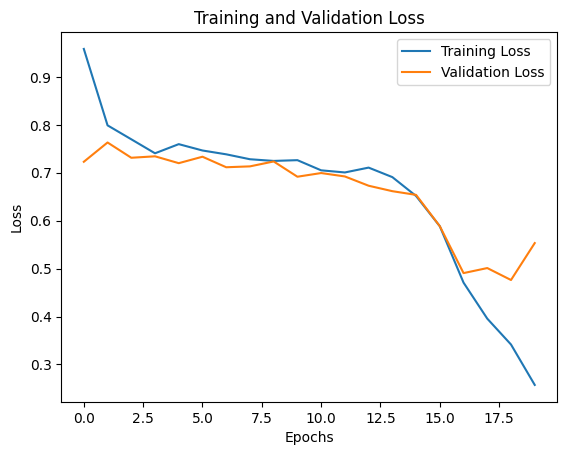

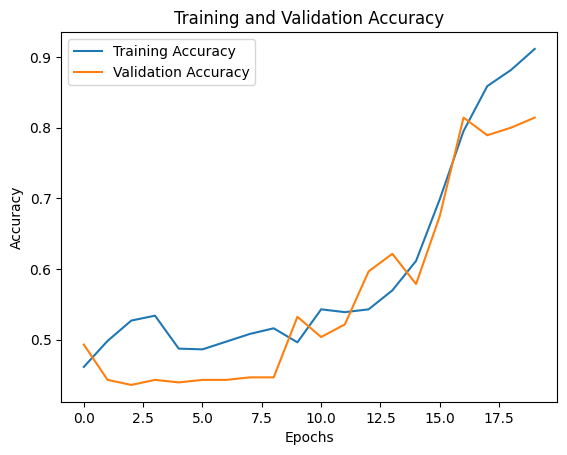

In [30]:
# Trực quan hóa độ mất mát (loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Trực quan hóa độ chính xác (accuracy)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [31]:
model.load_weights('model_cnn_bilstm.h5')
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 24ms/step - loss: 0.3212 - accuracy: 0.8929


[0.3212272524833679, 0.8928571343421936]

In [32]:
import pandas as pd
import os

# Kiểm tra xem tệp Excel đã tồn tại hay chưa
if dataset=='SmallData.csv':
    if os.path.isfile('evaluation_results.xlsx'):
        # Đọc tệp Excel hiện có
        df_existing = pd.read_excel('evaluation_results.xlsx', index_col=0)
        results = model.evaluate(X_test, y_test)
        # Nếu dòng đã tồn tại, không thực hiện thêm giá trị mà chỉ ghi đè lên
        df_existing.loc['SmallDataCnn_LSTM'] = [results[0], results[1]]
        df_existing.to_excel('evaluation_results.xlsx')
    else:
        # Đánh giá mô hình trên tập dữ liệu kiểm tra và lấy kết quả
        results = model.evaluate(X_test, y_test)

        # Tạo DataFrame từ kết quả
        df = pd.DataFrame([results], columns=['Loss', 'Accuracy'], index=['SmallDataCnn_LSTM'])

        # Lưu DataFrame vào tệp Excel
        df.to_excel('evaluation_results.xlsx')

if dataset=='BigData.csv':
    if os.path.isfile('evaluation_results.xlsx'):
        # Đọc tệp Excel hiện có
        df_existing = pd.read_excel('evaluation_results.xlsx', index_col=0)
        results = model.evaluate(X_test, y_test)
        # Nếu dòng đã tồn tại, không thực hiện thêm giá trị mà chỉ ghi đè lên
        df_existing.loc['BigDataCnn_LSTM'] = [results[0], results[1]]
        df_existing.to_excel('evaluation_results.xlsx')
    else:
        # Đánh giá mô hình trên tập dữ liệu kiểm tra và lấy kết quả
        results = model.evaluate(X_test, y_test)

        # Tạo DataFrame từ kết quả
        df = pd.DataFrame([results], columns=['Loss', 'Accuracy'], index=['BigDataCnn_LSTM'])

        # Lưu DataFrame vào tệp Excel
        df.to_excel('evaluation_results.xlsx')

4/4 [==============================] - 0s 27ms/step - loss: 0.3212 - accuracy: 0.8929


In [33]:
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print("Text preprocessed: ", input_text_pre_accent)
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=50)
    return vec_data


def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {'Tiêu cực': 0, 'Tích cực': 1}
    label = list(label_dict.keys())
    return label[int(result)], conf


def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer_data)
    result, conf = inference_model(input_model, model)
    return result, conf


my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open(r"tokenizer_data.pkl", "rb")as input_file:
    my_tokenizer = pickle.load(input_file)
print(prediction("tôi rất thích sản phẩm này ",my_tokenizer,my_model))


Text preprocessed:  tôi rất thích sản_phẩm này
('Tích cực', 0.9556497931480408)
